In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
import cv2

In [ ]:
# Cell 2: Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert the numpy arrays to PyTorch tensors
train_images_tensor = torch.from_numpy(train_images).float()
train_labels_tensor = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

# Create TensorDatasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Cell 3: Image enhancement and preprocessing
# Function to enhance and preprocess images
def enhance_image(image, method='histogram_equalization'):
    if method == 'histogram_equalization':
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        enhanced = cv2.equalizeHist(image)
        enhanced = enhanced.astype(float) / 255.0
    elif method == 'adaptive_histogram_equalization':
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(image)
        enhanced = enhanced.astype(float) / 255.0
    else:
        enhanced = image
    return enhanced


In [ ]:
# Cell 4: Spike train generation and visualization
# Function to generate spike trains using temporal encoding
def generate_spike_train_temporal(image, time_steps=100):
    spike_train = np.zeros((image.shape[0], image.shape[1], time_steps))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            spike_time = int((1 - image[i, j]) * time_steps)
            if spike_time < time_steps:
                spike_train[i, j, spike_time] = 1
    return spike_train

# Function to plot spike trains for multiple pixels
def plot_multiple_spike_trains(spike_train, pixel_coords, time_steps):
    plt.figure(figsize=(12, 8))
    for i, (row, col) in enumerate(pixel_coords):
        plt.subplot(len(pixel_coords), 1, i + 1)
        plt.plot(spike_train[row, col, :], marker='o', markersize=3)
        plt.title(f'Spike train for pixel at ({row}, {col})')
        plt.ylabel('Spike')
        plt.ylim(-0.2, 1.2)
        plt.xlabel('Time steps')
    plt.tight_layout()
    plt.show()

# Function to process and visualize spikes
def process_and_visualize_spikes(image, pixel_coords, time_steps=100, enhancement_method='histogram_equalization'):
    enhanced_image = enhance_image(image, method=enhancement_method)
    spike_train = generate_spike_train_temporal(enhanced_image, time_steps)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image, cmap='gray')
    plt.title('Enhanced Image')
    plt.axis('off')
    plt.show()

    plot_multiple_spike_trains(spike_train, pixel_coords, time_steps)


In [ ]:
# Cell 5: Define the Deep Q-Network
class DeepQNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Dynamically calculate the input size based on the time steps
time_steps = 50
input_size = 28 * 28 * time_steps
hidden_size = 128
output_size = 10

model = DeepQNetwork(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Cell 6: Training the Deep RL model
def train_deep_rl(model, train_loader, num_epochs, time_steps):
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data / 255.0

            spike_data = torch.stack([
                torch.from_numpy(generate_spike_train_temporal(img.numpy(), time_steps)) for img in data
            ])
            spike_data = spike_data.view(spike_data.size(0), -1).float()

            output = model(spike_data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")


In [ ]:

# Cell 7: Testing the model
def test_deep_rl(model, test_loader, time_steps):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data / 255.0
            spike_data = torch.stack([
                torch.from_numpy(generate_spike_train_temporal(img.numpy(), time_steps)) for img in data
            ])
            spike_data = spike_data.view(spike_data.size(0), -1).float()
            output = model(spike_data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

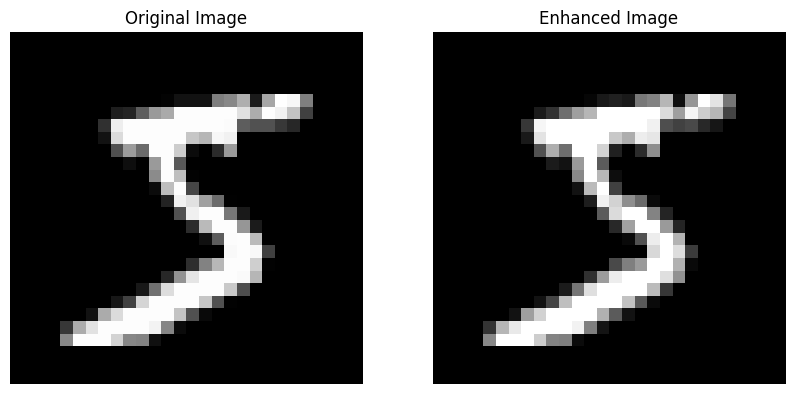

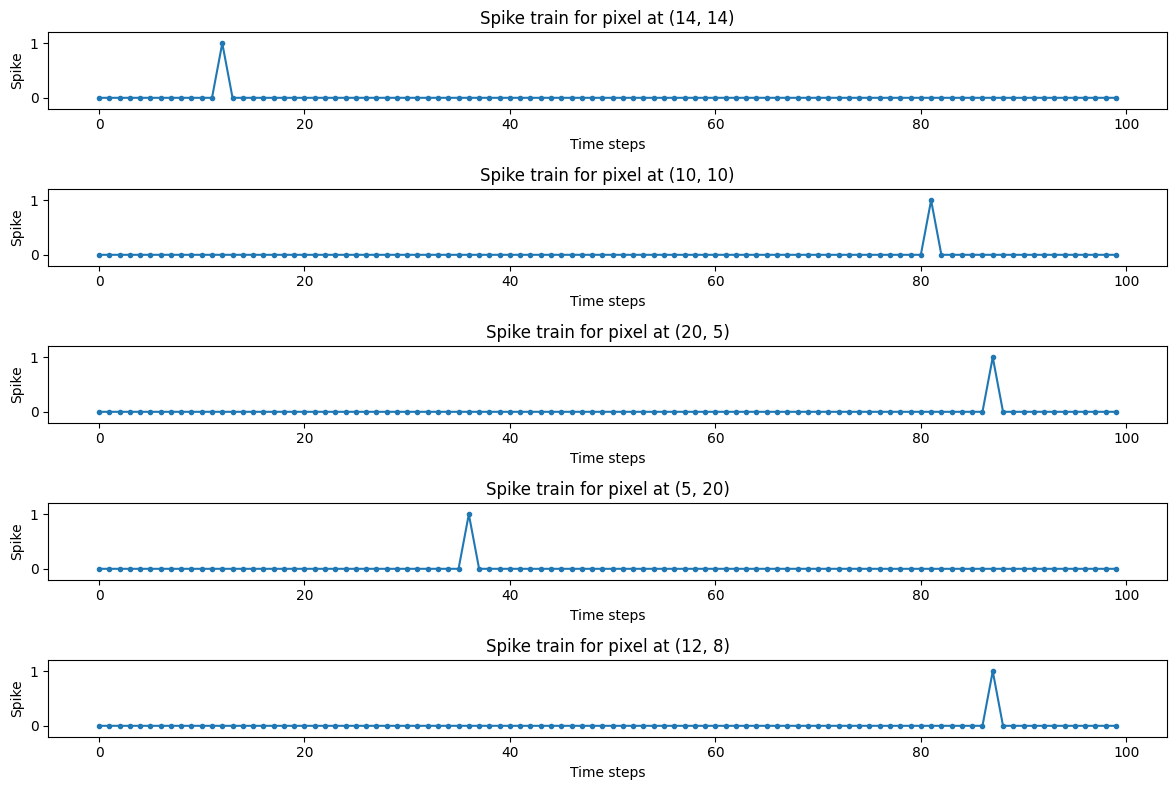

Epoch 1/5, Loss: 0.6079
Epoch 2/5, Loss: 0.0287
Epoch 3/5, Loss: 0.0235
Epoch 4/5, Loss: 0.0136
Epoch 5/5, Loss: 0.0527
Test Accuracy: 96.92%


In [ ]:
# Cell 8: Combine visualization and RL process
def main():
    sample_image = train_images[0]
    pixels_to_visualize = [(14, 14), (10, 10), (20, 5), (5, 20), (12, 8)]
    process_and_visualize_spikes(sample_image, pixels_to_visualize, enhancement_method='adaptive_histogram_equalization')
    train_deep_rl(model, train_loader, num_epochs=5, time_steps=50)
    test_deep_rl(model, test_loader, time_steps=50)

if __name__ == "__main__":
    main()
